In [1]:
#**************************************************************************************
#
#    Title: <YoanoGAN-OOP Style>
#    Author: <Ege Demir>
#    Date: <6/26/1011>
#    Code version: <0.1>
#
#**************************************************************************************


In [2]:
import glob
import pandas as pd
import imageio
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import PIL
from tensorflow.keras import layers 
import time
import tensorflow as tf
from IPython import display
from IPython.display import clear_output
from keras.initializers import RandomNormal
from PIL import Image
from datetime import datetime
import io

In [3]:
matplotlib.use('Agg')

# Load and prepare dataset

In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128

In [4]:
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.mnist.load_data()

In [5]:
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels  = tf.keras.utils.to_categorical(test_labels,  10)

In [6]:
amount_to_Cut = int(np.floor((np.ma.size(train_images,axis=0)/BATCH_SIZE))*BATCH_SIZE)

train_images = train_images[:amount_to_Cut,:,:]
train_labels = train_labels[:amount_to_Cut,:]


In [7]:
train_images = (train_images) / 256  # Normalize the images to [0, 1]
train_images = train_images.astype(np.float32)

test_images = (test_images) / 256
test_images = test_images.astype(np.float32)

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 0., 1., 1., 1.], dtype=float32)>

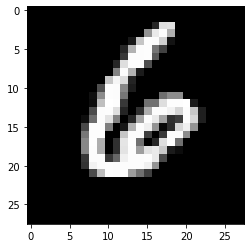

In [11]:
image_index = 13
plt.plot()
plt.imshow(train_images[image_index,:, :], cmap='gray')
#(tf.ones_like(train_labels[image_index])-train_labels[image_index])/9
tf.ones_like(train_labels[image_index])-(train_labels[image_index])

In [12]:
# Batch and shuffle the data
dataset = tf.data.Dataset.from_tensor_slices((train_images,train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
#train_Output = tf.data.Dataset.from_tensor_slices(train_labels).batch(BATCH_SIZE)

# Custom Layers

# Custom Models

## Generator

In [13]:
def make_generator_model(latent_dim,class_Amt):
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim+class_Amt,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

## Discriminator

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(10))

    return model

# Define Loss and Optimizers

In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy_categorical = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
cross_entropy_binary = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [16]:
def discriminator_loss(y_pred,y_real):
    return cross_entropy_categorical(y_real,y_pred)

In [17]:
def generator_loss(y_pred,y_real):

#     indices = tf.math.argmax(y_real,axis=1)

#     arr = []
#     for i in range(BATCH_SIZE):
#       arr.append(y_pred[i,indices[i]])

#     final_cross_entropy = cross_entropy_binary(tf.zeros_like(indices),arr)
    
    final_cross_entropy = cross_entropy_categorical((tf.ones_like(y_real)-(y_real)),y_pred)
    
    return final_cross_entropy






# Define Callbacks

In [18]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

# Define training loop

In [22]:
class YoanoGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim,lmbd=0.7):
        super(YoanoGAN, self).__init__()

        #Assigning models as class variables
        self.discriminator = discriminator
        self.generator = generator
        
        #Initialize batch counter
        self.currentBatch = 0
        
        #Save model hyperparameters
        self.latent_dim = latent_dim
        self.lmbd = lmbd

        
        #Fix seed for visualization
        self.rand_y = [0,0,0,1,1,1,2,2,2]
        fix_labels = tf.keras.utils.to_categorical(self.rand_y, 10)
        self.seed = np.append(fix_labels,tf.random.normal([9, latent_dim]),axis=1)
        
        #Define tracker variables for training metrics
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.norm_tracker = tf.keras.metrics.Mean(name="gen_output_norm")
        self.w_noise_accuracy_tracker = tf.keras.metrics.Accuracy(name="w_noise_accuracy")
        #self.wo_noise_accuracy_tracker = tf.keras.metrics.Accuracy(name="wo_noise_accuracy")
        
        
    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker,self.norm_tracker,self.w_noise_accuracy_tracker,self.wo_noise_accuracy_tracker]
    


    #Function for generating noises for visualization in Tensorboard
    def save_gen_output(self):
        generated_images = self.generator(self.seed) * self.lmbd
        fig = plt.figure(figsize=(8, 10))
        fig.suptitle('Generated Noises', fontsize=15)
        
        for i, y in enumerate(self.rand_y):
            plt.subplot(3, 3, i+1)
            plt.title(str(y))
            plt.imshow(generated_images[i, :, :, 0], cmap='gray',vmin=0, vmax=1)
            plt.axis('off')
            
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        image = tf.expand_dims(image, 0)
        tf.summary.image("Generator Output Images", image, step=self.currentBatch)
        plt.close(fig)

        
    
    #Function for calculating norm
    def get_norm(self,noise):
        norm_calculated = tf.norm(noise,ord=2,axis=[1,2])
        norm_mean = tf.math.reduce_mean(norm_calculated)
        return norm_mean
    
    def compile(self, d_optimizer, g_optimizer, dis_loss_fn, gen_loss_fn):
        super(YoanoGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.dis_loss_fn = dis_loss_fn
        self.gen_loss_fn = gen_loss_fn

    #Training Step
    def train_step(self, data):
        
        self.currentBatch = self.currentBatch + 1
        
        #Import data and infer batch size
        x, y = data
        BATCH_SIZE = tf.shape(x)[0]
        
        #Cast x to float32 to match with generator output type (Otherwise adding the two gives an error) 
        x = tf.cast(x, tf.float32)
        
        #Append normal noise and one hot labeled y data together for generator input.
        gen_in = tf.experimental.numpy.append(y, tf.random.normal([BATCH_SIZE, self.latent_dim]), axis=1)
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            #Run the generator and generate noises
            generated_noise = self.generator(gen_in, training=True)
            generated_noise = tf.squeeze(generated_noise * self.lmbd) #Squeezing to remove axis-1 with 1 dimension.
            
            #Check discriminator output by adding noise and x of dataset.
            disc_output = self.discriminator(generated_noise+x, training=True)
            
            #Calculate loss values for both models.
            gen_loss = self.gen_loss_fn(disc_output,y)
            disc_loss = self.dis_loss_fn(disc_output,y)
            
        
        #Calculate and apply gradients for both models.
        if(True):
            gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
    
        if(True):
            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        
        
        #Calculate norm of generated noise
        norm = self.get_norm(generated_noise)
        
        #Save noises generated from seeds every 10 batch
        if(self.currentBatch % 10 == 0):
            self.save_gen_output()
        
        
        
        #Update and return metrics
        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_loss_tracker.update_state(disc_loss)
        self.norm_tracker.update_state(norm)
        self.w_noise_accuracy_tracker.update_state(tf.argmax(y, axis=1),tf.argmax(disc_output, axis=1))


        tf.summary.scalar('Generator Loss', data=self.gen_loss_tracker.result(), step=self.currentBatch)
        tf.summary.scalar('Discriminator Loss', data=self.disc_loss_tracker.result(), step=self.currentBatch)
        tf.summary.scalar('Generator Norm', data=self.norm_tracker.result(), step=self.currentBatch)
        tf.summary.scalar('With Noise Accuracy', data=self.w_noise_accuracy_tracker.result(), step=self.currentBatch)


        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "norm": self.norm_tracker.result(),
            "With Noise Accuracy": self.w_noise_accuracy_tracker.result()
        }


In [23]:
generator = make_generator_model(latent_dim=120,class_Amt=10)
discriminator = make_discriminator_model()

yoano_gan = YoanoGAN(
    discriminator=discriminator, generator=generator, latent_dim=120,lmbd=0.8
)

yoano_gan.compile(
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003),
    dis_loss_fn = discriminator_loss,
    gen_loss_fn = generator_loss
)




In [24]:
tf.config.run_functions_eagerly(True) #Figure out how to do graph execution

In [ ]:
yoano_gan.fit(dataset,batch_size=128, epochs=20)

Epoch 1/20
468/468 [==============================] - 56s 120ms/step - g_loss: 23.9243 - d_loss: 1.9626 - norm: 9.3047 - With Noise Accuracy: 0.5993 - Without Noise Accuracy: 0.8897
Epoch 2/20
468/468 [==============================] - 50s 106ms/step - g_loss: 39.0956 - d_loss: 0.9803 - norm: 9.1040 - With Noise Accuracy: 0.5992 - Without Noise Accuracy: 0.8862
Epoch 3/20
468/468 [==============================] - 52s 111ms/step - g_loss: 58.6819 - d_loss: 0.5211 - norm: 10.8018 - With Noise Accuracy: 0.5097 - Without Noise Accuracy: 0.8880
Epoch 4/20
161/468 [=========>....................] - ETA: 34s - g_loss: 67.6737 - d_loss: 0.4245 - norm: 11.9095 - With Noise Accuracy: 0.3685 - Without Noise Accuracy: 0.8865

KeyboardInterrupt: 

In [ ]:
EPOCHS = 500
latent_dim = 120
num_examples_to_generate = 9

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)




# Tensorboard

In [25]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [26]:
%tensorboard --samples_per_plugin=images=500 --logdir logs/scalar

<IPython.core.display.Javascript object>

# Test with Attacker

In [ ]:
def test_model_w_attacker():
  #Prepare y values and random values for input to generator
  rand_y_in = tf.experimental.numpy.append(test_labels, tf.random.normal([test_labels.shape[0], latent_dim]), axis=1)
  
  #Generate noises for rand_y_in
  generated_noise = yoano_gan.generator(rand_y_in)
  generated_noise = generated_noise * 0.7
  generated_noise = tf.squeeze(generated_noise)

  #Add noises to x images
  noisy_images = generated_noise.numpy()+test_images

  #Create a new attacker model that has the same architecture as GAN discriminator, and try to fit to noisy x inputs
  attacker_model = make_discriminator_model()
  attacker_model.compile(optimizer=tf.keras.optimizers.Adam(),loss=cross_entropy_categorical,metrics=["accuracy"])
  return attacker_model.fit(noisy_images,test_labels,validation_split=0.3,epochs=2)

In [ ]:
test_model_w_attacker()

Epoch 1/2
219/219 [==============================] - 4s 18ms/step - loss: 0.4252 - accuracy: 0.8719 - val_loss: 0.0118 - val_accuracy: 0.9997
Epoch 2/2
219/219 [==============================] - 4s 18ms/step - loss: 0.0109 - accuracy: 0.9990 - val_loss: 0.0021 - val_accuracy: 1.0000
